# Sales Prediction Based on e-Commerce Patterns Recognition
![eCommerce](Images/eCommerce.jpg)
## Objective:
<p align="justify">
Predict browsing sessions leading to eCommerce purchases. Extreme Gradient Boosting is the algorithm of choice due to the imbalanced nature of the data set (which is handled through SMOTE). Results include evaluation metrics, confusion matrix, R.O.C. curve and the extraction of the features influencing online purchases the most. The analysis offers practical implications of predictive analytics in business, highlighting potential applications in marketing strategies, dynamic pricing, platform optimisation, inventory management, and strategic planning.
</p>


[Online shoppers.csv](https://github.com/justgrossi/Portfolio/blob/main/1.Sales_Prediction/online_shoppers.csv)

<p align="justify">
The data set consists of 10 numerical and 8 categorical attributes for a total of 12,330 browsing sessions. Each session belongs to a different user. Of the 12,330 sessions in the dataset 84.5% are negative class samples that did not end with a purchase. Following variables list:

1. "*Administrative*", "*Administrative Duration*", "*Informational*", "*Informational Duration*", "*Product Related*" and "*Product Related Duration*" represent the number of different types of pages visited by the visitor in that session and the total time spent on each of those page categories.
2. "*Bounce Rate*", "*Exit Rate*" and "*Page Value*" represent the metrics measured by Google Analytics for each page. The "*Bounce Rate*" refers to the percentage of visitors who enter the site from that page and then leave ("*bounce*") without triggering any other requests to the analytics server during that session. "*Exit Rate*" is calculated as for all pageviews to the page, the percentage that were the last in the session. "*Page Value*" represents the average value of a web page that a user visited before completing an e-commerce transaction.
3. "*Special Day*" indicates the closeness (in days) of the browsing session to a specific special day (e.g. Mother’s Day, Valentine's Day) in which sessions are more likely to lead to a transaction.
4. The data set also includes information regarding operating system, browser, region, traffic type, visitor type (returning vs new visitor), a Boolean value indicating whether the date of the visit is weekend, and month of the year.
5. "*Revenue*" is the boolean target label identifying browsing sessions ending in a purchase.
</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

In [2]:
# Set helper functions
# Data exploration
def load_and_inspect_data(file_path):
    """Load the dataset and perform initial inspection"""
    print("=" * 60)
    print("LOADING AND INSPECTING DATA")
    print("=" * 60)
    
    # Load the data
    df = pd.read_csv(file_path)
    
    print(f"Dataset shape: {df.shape}")
    print(f"\nColumn names and types:")
    print(df.dtypes)
    
    print(f"\nMissing values per column:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    display(df.head())

    return df


# Check integrity numerical features
def num_features(cols):
    for col in num_cols:
        print(f'Column: {col}')
        negative_values=len(df.loc[df[col]<0])
        print(f'Negative values: {negative_values}')


# Get Feature importances -- best 10
def feature_importance_list(best_model):
    # Get final estimator -- the actual model
    final_estimator = best_model.named_steps["classifier"]

    if hasattr(final_estimator, "feature_importances_"):
        importances = final_estimator.feature_importances_

        # Get feature names after preprocessing
        preprocessor = best_model.named_steps["preprocessor"]
        try:
            feature_names = preprocessor.get_feature_names_out()
        except:
            feature_names = X_train.columns  # fallback

        # Build DataFrame
        importance_df = (
            pd.DataFrame({"Feature": feature_names, "Importance": importances})
            .sort_values("Importance", ascending=False)
        ).head(10)

        print("\nFeature Importances:")
        print(importance_df)

    elif hasattr(final_estimator, "coef_"):
        importances = (
            final_estimator.coef_[0]
            if len(final_estimator.coef_.shape) > 1
            else final_estimator.coef_
        )

        preprocessor = best_model.named_steps["preprocessor"]
        try:
            feature_names = preprocessor.get_feature_names_out()
        except:
            feature_names = X_train.columns  # fallback
    
        importance_df = (
            pd.DataFrame({"Feature": feature_names, "Coefficient": importances})
            .sort_values("Coefficient", ascending=False)
        ).head(10)
    
        print("\nModel Coefficients:")
        print(importance_df)

    else:
        print("This model does not provide feature importances or coefficients.")


# Plot Feature importances
def plot_feature_importance(best_model):
    plt.style.use('ggplot')

    final_estimator = best_model.named_steps["classifier"]
    importances = final_estimator.feature_importances_
    plt.hist(importances, bins=20)
    
    plt.title("Distribution of Feature Importances")
    plt.xlabel("Feature Importance")
    plt.ylabel("Number of Features")
    plt.tight_layout()
    plt.show()


# Plot ROC curve
def roc_curve_plot(best_model):
    from sklearn.metrics import roc_curve as sk_roc_curve, auc
    from sklearn.preprocessing import label_binarize
    # ROC Curve
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)

        if len(np.unique(y_test)) == 2:
            # Binary classification
            fpr, tpr, _ = sk_roc_curve(y_test, y_proba[:, 1])
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(6, 6))
            plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Receiver Operating Characteristic (ROC)")
            plt.legend(loc="lower right")
            plt.show()

        else:
            # Multi-class classification (one-vs-rest)
            from sklearn.preprocessing import label_binarize
            from sklearn.metrics import sk_roc_curve, auc
    
            classes = np.unique(y_test)
            y_test_bin = label_binarize(y_test, classes=classes)
    
            plt.figure(figsize=(8, 6))
            for i in range(len(classes)):
                fpr, tpr, _ = sk_roc_curve(y_test_bin[:, i], y_proba[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")
    
            plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Multi-class ROC Curve")
            plt.legend(loc="lower right")
            plt.show()

    else:
        print("This model does not support predict_proba, ROC curve not available.")+


# Save best model for later use
def save_best_model(best_model):
    import joblib
    joblib.dump(best_model, "best_model.pkl")
    print("✅ Model saved as best_model.pkl")
    
    # Load the model
    loaded_model = joblib.load("best_model.pkl")
    print("✅ Model reloaded successfully")
    
    # Confirm reloaded model works
    y_pred_loaded = loaded_model.predict(X_test)
    print("Reloaded model Accuracy:", accuracy_score(y_test, y_pred_loaded))

In [3]:
file_path='online_shoppers.csv'
df=load_and_inspect_data(file_path)

LOADING AND INSPECTING DATA
Dataset shape: (12330, 18)

Column names and types:
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Missing values per column:
Series([], dtype: int64)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
# Standardize columns naming
df.columns=df.columns.str.lower()
df.columns=df.columns.str.strip()
df.columns=df.columns.str.replace('_', '')

In [5]:
# Set columns names
mapper={
    'administrative':'admin',
    'administrativeduration':'adminDur',
    'informational': 'info',
    'informationalduration':'infoDur',
    'productrelated':'prodRel',
    'productrelatedduration':'prodRelDur',
    'operatingsystems':'operatingSys',
    'traffictype':'trafficType',
    'visitortype':'visitType'
}
df.rename(columns=mapper, inplace=True)

In [6]:
# Check integrity numerical features
num_cols=['adminDur', 'infoDur', 'prodRelDur', 'bouncerates', 'exitrates', 'pagevalues']
num_features(num_cols)

Column: adminDur
Negative values: 0
Column: infoDur
Negative values: 0
Column: prodRelDur
Negative values: 0
Column: bouncerates
Negative values: 0
Column: exitrates
Negative values: 0
Column: pagevalues
Negative values: 0


In [7]:
# Check values
df['visitType'].value_counts()

visitType
Returning_Visitor    10543
New_Visitor           1660
New                     65
new                     38
Returning               14
returning                5
ret                      5
Name: count, dtype: int64

In [8]:
type_mapping={
    'Returning_Visitor': 'Returning',
    'Returning': 'Returning',
    'returning': 'Returning',
    'ret': 'Returning',
    'New_Visitor' : 'New',
    'new' : 'New',
    'New' : 'New'
}

In [9]:
df['visitType'] = df['visitType'].map(type_mapping)

In [10]:
df['month'].value_counts()

month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64

In [11]:
df.isna().sum()

admin           0
adminDur        0
info            0
infoDur         0
prodRel         0
prodRelDur      0
bouncerates     0
exitrates       0
pagevalues      0
specialday      0
month           0
operatingSys    0
browser         0
region          0
trafficType     0
visitType       0
weekend         0
revenue         0
dtype: int64

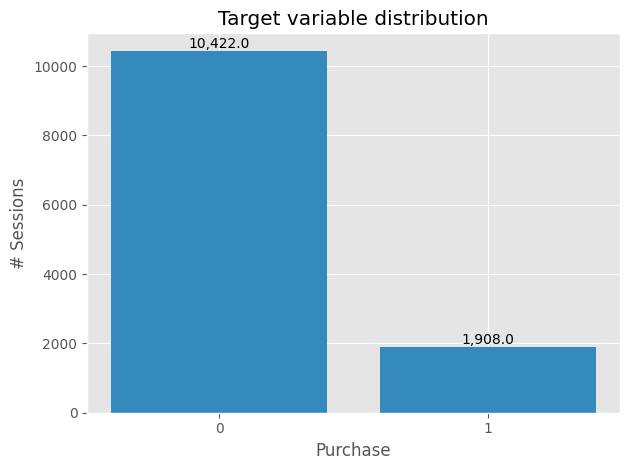

In [12]:
# Plot Target Label distribution
plt.style.use('ggplot')

x=df['revenue'].value_counts().index
y=df['revenue'].value_counts().values

plt.bar(x, y)
bars = plt.bar(x, y)
plt.bar_label(bars, fmt='{:,}')
plt.title('Target variable distribution')
plt.xticks([0, 1])
plt.xlabel('Purchase')
plt.ylabel('# Sessions')

plt.tight_layout()
plt.show()

In [13]:
# Split into train test
X=df.drop(columns=['revenue'])
y=df['revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
# Define preprocessing for numeric and categorical columns
numeric_features = X.drop(columns=["month", "visitType", "weekend"]).columns
categorical_features = ["month", "visitType", "weekend"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
# Combine them with ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# Create final pipeline + SMOTE
clf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", XGBClassifier())
])

In [15]:
param_grid= {
            "classifier__n_estimators": [150, 200, 300],
            "classifier__max_depth": [3, 5, 7],
            "classifier__learning_rate": [0.01, 0.1, 0.2]
        }

In [16]:
# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=clf_pipeline,
param_distributions=param_grid,
n_iter=20,
cv=5,
n_jobs=-1,
verbose=0,
random_state=42)

In [17]:
# Train & Evaluate
random_search.fit(X_train, y_train)


# Best model
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_


# Predictions
y_pred = best_model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1}
Accuracy: 0.8937550689375506
F1 Score: 0.893294693620504
Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.94      0.94      2084
        True       0.66      0.65      0.65       382

    accuracy                           0.89      2466
   macro avg       0.80      0.79      0.80      2466
weighted avg       0.89      0.89      0.89      2466



In [18]:
# 10 Most important features
feature_importance_list(best_model)


Feature Importances:
                     Feature  Importance
8            num__pagevalues    0.314505
21            cat__month_Nov    0.103356
20            cat__month_May    0.062281
23            cat__month_Sep    0.059870
19            cat__month_Mar    0.049897
25  cat__visitType_Returning    0.041115
12               num__region    0.032791
10         num__operatingSys    0.030506
24        cat__visitType_New    0.030467
13          num__trafficType    0.029175


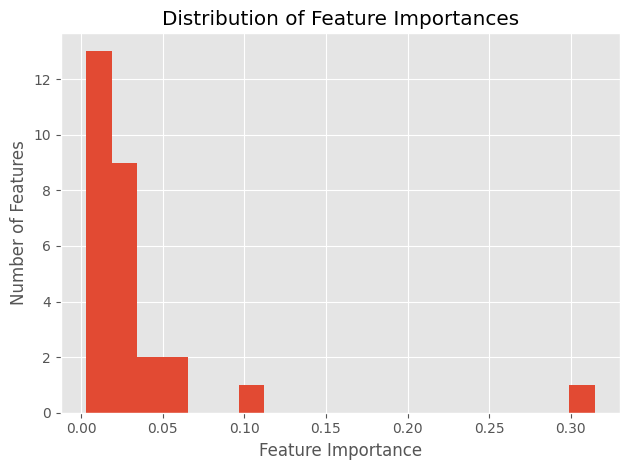

In [19]:
# Plot all Feature importances
plot_feature_importance(best_model)

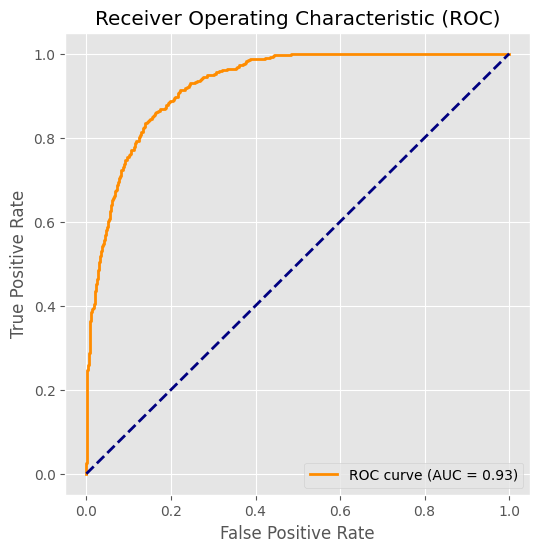

In [20]:
# Model ROC curve
roc_curve_plot(best_model)

In [21]:
# Save the model
# save_best_model(best_model)

✅ Model saved as best_model.pkl
✅ Model reloaded successfully
Reloaded model Accuracy: 0.8937550689375506
